# **Automated Machine Learning**

---

### **Reptile-Based Few-Shot Intrusion Detection System**
 *Author: Vladislav Zagidulin (2026)*<br>
 *Supervisor: Prof. Marwa Elsayed*

---

<font size="1"> Based on the Reptile meta-learning algorithm proposed by Alex Nichol and John Schulman [[1]](https://openai.com/research/reptile) and draws from the Torch Reptile implementation by Ruduan B. F. Plug [[2]](https://github.com/dualslash/reptile-torch)</font>
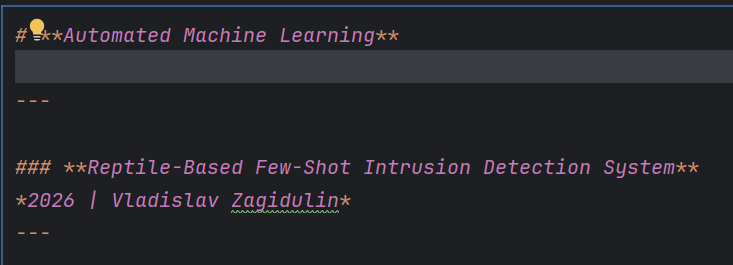

### Meta Libraries

In [40]:
# System Utility
import sys

# IPython Notebook Utilities
from IPython.display import clear_output
import tqdm.notebook as tqdm
clear_output()

print(sys.version)

3.11.9 (tags/v3.11.9:de54cf5, Apr  2 2024, 10:12:12) [MSC v.1938 64 bit (AMD64)]


### Packages

In [31]:
# Data Processing
import numpy as np

# Parallel Compute
import torch 
import torch.nn as nn

# Data Visualization
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

# Utility Libraries
from time import time
from copy import deepcopy

# Initialize Device
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print("Torch Version\t", torch.__version__)

Torch Version	 2.9.0+cpu


### Environment Configuration

In [32]:
data_folder = "data"
np.random.seed(int(time()))
torch.manual_seed(int(time()))

### Meta-Learning Framework

#### Reptile Class Definition

In [33]:
from sklearn.metrics import precision_score, recall_score, f1_score

class Reptile:

  def __init__(self, model, log, params):

    # Intialize Reptile Parameters
    self.inner_step_size = params[0]
    self.inner_batch_size = params[1]
    self.outer_step_size = params[2]
    self.outer_iterations = params[3]
    self.meta_batch_size = params[4]

    # Initialize Torch Model and Tensorboard
    self.model = model.to(device)
    self.log = log

  def reset(self):

    # Reset Training Gradients
    self.model.zero_grad()

  def train(self, x, y):

    # Train from Scratch
    self.reset()
    self.model.train()

    # Outer Training Loop
    for outer_iteration in tqdm.tqdm(range(self.outer_iterations)):

      # Track Current Weights
      current_weights = deepcopy(self.model.state_dict())

      # Sample a new Subtask
      (x_support, y_support), (x_query, y_query) = sample_task(
         x, y,
         allowed_classes=train_classes,
         n_way=N_WAY,
         k_shot=K_SHOT,
         query_size=QUERY_SIZE
      )

      x_support = x_support.to(device)
      y_support = y_support.to(device)
      x_query   = x_query.to(device)
      y_query   = y_query.to(device)

      # Inner Training Loop
      for inner_iteration in range(self.inner_batch_size):

        perm = torch.randperm(x_support.shape[0])

        # Process Meta Learning Batches
        for batch in range(0, x_support.shape[0], self.meta_batch_size):

          # Get Permuted Batch from Sample
          idx = perm[batch:batch + self.meta_batch_size]

          # Calculate Batch Loss
          self.model.zero_grad()
          batch_loss = self.loss(x_support[idx], y_support[idx])
          batch_loss.backward()

          # Update Model Parameters
          for theta in self.model.parameters():

            if theta.grad is not None:
                theta.data -= self.inner_step_size * theta.grad.data

      # Compute meta-loss
      with torch.no_grad():
         query_loss = self.loss(x_query, y_query)

      # Linear Cooling Schedule
      alpha = self.outer_step_size * (1 - outer_iteration / self.outer_iterations)

      # Get Current Candidate Weights
      candidate_weights = self.model.state_dict()

      # Transfer Candidate Weights to Model State Checkpoint
      state_dict = {candidate: (current_weights[candidate] + alpha * 
                               (candidate_weights[candidate] - current_weights[candidate])) 
                                for candidate in candidate_weights}
      self.model.load_state_dict(state_dict)
      
      # Log new Training Loss
      self.log.add_scalar('ModelEstimate/Loss', query_loss.item(), outer_iteration)

      # Log evaluation accuracy and precision
      if outer_iteration % 50 == 0:
        mean_acc, _, mean_prec, _, mean_rec, _, mean_f1, _ = evaluate_episodes(self, x, y, allowed_classes=train_classes, n_episodes=50)

        self.log.add_scalar('Episode/MeanAccuracy', mean_acc, outer_iteration)
        self.log.add_scalar('Episode/MeanPrecision', mean_prec, outer_iteration)
        self.log.add_scalar('Episode/MeanRecall', mean_rec, outer_iteration)
        self.log.add_scalar('Episode/MeanF1', mean_f1, outer_iteration)

  def loss(self, x, y):
    # Compute model output
    logits = self.model(x)

    # Cross Entropy Loss
    calculatedLoss = nn.CrossEntropyLoss()
    output = calculatedLoss(logits, y)

    return output

  def predict(self, x):

    # Estimate using Torch Model
    t = torch.tensor(x, device = device, dtype = torch.float32)
    t = self.model(t)

    prediction = torch.argmax(t, dim=1)

    return prediction.cpu().numpy()

  def eval(self, x, y, allowed_classes, gradient_steps=5):
      self.model.eval()

      # Sample a task
      (x_support, y_support), (x_query, y_query) = sample_task(
         x, y,
         allowed_classes=allowed_classes,
         n_way=N_WAY,
         k_shot=K_SHOT,
         query_size=QUERY_SIZE
      )

      x_support = x_support.to(device)
      y_support = y_support.to(device)
      x_query   = x_query.to(device)
      y_query   = y_query.to(device)

      # Store Meta-Initialization Weights
      meta_weights = deepcopy(self.model.state_dict())

      # Calculate Estimate over Gradient Steps
      for step in range(gradient_steps):

        # Calculate Evaluation Loss and Backpropagate
        self.model.zero_grad()
        loss = self.loss(x_support, y_support)
        loss.backward()

        # Update Model Estimate Parameters
        for theta in self.model.parameters():

            if theta.grad is not None:
                theta.data -= self.inner_step_size * theta.grad.data

      # Get Estimate Loss over Evaluation
      with torch.no_grad():
          logits = self.model(x_query)
          predictions = torch.argmax(logits, dim=1)

      # Accuracy
      accuracy = (predictions == y_query).float().mean().item()

      # Precision
      precision = precision_score(
          y_query.cpu().numpy(),
          predictions.cpu().numpy(),
          average='macro',
          zero_division=0
      )

      # Recall
      recall = recall_score(
          y_query.cpu().numpy(),
          predictions.cpu().numpy(),
          average='macro',
          zero_division=0
      )

      # F1 Score
      f1 = f1_score(
          y_query.cpu().numpy(),
          predictions.cpu().numpy(),
          average='macro',
          zero_division=0
      )

      # Restore Meta-Initialization Weights
      self.model.load_state_dict(meta_weights)
      self.model.train()

      return accuracy, precision, recall, f1

def evaluate_episodes(model, x, y, allowed_classes, n_episodes, gradient_steps=5):
    accs, precs, recs, f1s = [], [], [], []
    for _ in range(n_episodes):
        acc, prec, rec, f1 = model.eval(x, y, allowed_classes=allowed_classes, gradient_steps=gradient_steps)
        accs.append(acc)
        precs.append(prec)
        recs.append(rec)
        f1s.append(f1)
    return (
        np.mean(accs), np.std(accs),
        np.mean(precs), np.std(precs),
        np.mean(recs), np.std(recs),
        np.mean(f1s), np.std(f1s)
    )

#### Task Sampler

In [34]:
N_WAY = 3       # number of classes per episode
K_SHOT = 5      # support samples per class
QUERY_SIZE = 15  # query samples per class
HIDDEN_DIM = 128

def sample_task(x, y, allowed_classes, n_way=N_WAY, k_shot=K_SHOT, query_size=QUERY_SIZE):
    # Work with numpy view of labels
    y_np = y.cpu().numpy()
    needed = k_shot + query_size

    # Only classes that are allowed and have enough samples
    valid_classes = [
        c for c in allowed_classes
        if np.sum(y_np == c) >= needed
    ]

    if len(valid_classes) < n_way:
        raise ValueError("Not enough valid classes for this N-way task")

    # Randomly choose n_way classes from the valid ones
    classes = np.random.choice(valid_classes, n_way, replace=False)

    support_x = []
    support_y = []
    query_x = []
    query_y = []

    # Map global label -> episodic label 0..n_way-1
    class_mapping = {int(c): i for i, c in enumerate(classes)}

    for c in classes:
        idx = np.where(y_np == c)[0]             # indices of this class
        chosen = np.random.choice(idx, needed, replace=False)

        support = chosen[:k_shot]
        query = chosen[k_shot:]

        support_x.append(x[support])
        query_x.append(x[query])

        # Episodic labels 0..n_way-1
        episodic_label = class_mapping[int(c)]
        support_y.append(torch.full((len(support),), episodic_label, dtype=torch.long))
        query_y.append(torch.full((len(query),), episodic_label, dtype=torch.long))

    x_support = torch.cat(support_x, dim=0)
    y_support = torch.cat(support_y, dim=0)
    x_query = torch.cat(query_x, dim=0)
    y_query = torch.cat(query_y, dim=0)

    return (x_support, y_support), (x_query, y_query)


#### PyTorch Module


In [35]:
class TorchModule(nn.Module):
    def __init__(self, input_dim, hidden_dim=HIDDEN_DIM, num_classes=N_WAY):
        super(TorchModule, self).__init__()

        self.input = nn.Linear(input_dim, hidden_dim)
        self.hidden = nn.Linear(hidden_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = torch.relu(self.input(x))
        x = torch.relu(self.hidden(x))
        return self.output(x)


### Dataset

#### Preprocessing

In [36]:
import pandas as pd
import torch
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE

# Load dataset
df = pd.read_csv("dataset/ML-EdgeIIoT-dataset-test.csv", low_memory=False)

# Drop unnecessary columns
drop_cols = [
    "frame.time",
    "ip.src_host",
    "ip.dst_host",
    "arp.src.proto_ipv4",
    "arp.dst.proto_ipv4",
    "http.file_data",
    "http.request.full_uri",
    "http.request.uri.query",
    "icmp.transmit_timestamp",
    "tcp.options",
    "tcp.payload",
    "tcp.srcport",
    "tcp.dstport",
    "udp.port",
    "mqtt.msg",
]

df.drop(columns=drop_cols, inplace=True, errors="ignore")

# Clean values
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(axis=0, how='any', inplace=True)
df.drop_duplicates(subset=None, keep="first", inplace=True)

# Encode categorical features
categorical_cols = [
    'http.request.method',
    'http.referer',
    'http.request.version',
    'dns.qry.name.len',
    'mqtt.conack.flags',
    'mqtt.protoname',
    'mqtt.topic',
]

df = pd.get_dummies(df, columns=categorical_cols)

# Separate features and labels
x = df.drop(columns=["Attack_type", "Attack_label"])

# Encode Attack_type labels
encoder = LabelEncoder()
y = encoder.fit_transform(df["Attack_type"])

# Standardize features
scaler = StandardScaler()
x = scaler.fit_transform(x)

# Convert to tensors
x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

print("Dataset loaded:", x.shape, y.shape)

Dataset loaded: torch.Size([152196, 74]) torch.Size([152196])


#### Split Data

In [37]:
# Get all unique class labels
all_classes = np.unique(y.numpy())

# Fix seed for reproducibility
np.random.seed(42)

# Choose 80% classes for meta-training
num_meta_train = int(0.8 * len(all_classes))
train_classes = np.random.choice(all_classes, size=num_meta_train, replace=False)

# Remaining classes are test
test_classes = np.array([c for c in all_classes if c not in train_classes])

print("Train Classes:", train_classes)
print("Test Classes:", test_classes)

# Create dataset masks
train_mask = np.isin(y.numpy(), train_classes)
test_mask  = np.isin(y.numpy(), test_classes)

# Filter datasets
x_train = x[train_mask]
y_train = y[train_mask]

x_test  = x[test_mask]
y_test  = y[test_mask]

print("Train set:", x_train.shape, y_train.shape)
print("Test set:",  x_test.shape,  y_test.shape)

# Increase sample of minority classes using SMOTE
# smote = SMOTE(k_neighbors=5, random_state=42)
#
# x_train_np = x_train.numpy()
# y_train_np = y_train.numpy()
# x_train_res, y_train_res = smote.fit_resample(x_train_np, y_train_np)

# print("Train set:", x_train.shape, y_train.shape)

Train Classes: [ 9 11  0 13  5  8  2  1 14  4  7 10]
Test Classes: [ 3  6 12]
Train set: torch.Size([131377, 74]) torch.Size([131377])
Test set: torch.Size([20819, 74]) torch.Size([20819])


## Experiments

### Results

In [38]:
# Define Experiment Parameters
inner_step_size = 0.02
inner_batch_size = 15

outer_step_size = 0.1
outer_iterations = 3000
meta_batch_size = 15

params = [inner_step_size, inner_batch_size,
          outer_step_size, outer_iterations, meta_batch_size]

# Build Model
input_dim = x.shape[1]
log = SummaryWriter(data_folder)
reptile_model = Reptile(TorchModule(input_dim, hidden_dim=HIDDEN_DIM, num_classes=N_WAY), log, params)

# Train Model
reptile_model.train(x_train, y_train)

log.close()

# Zero-day evaluation on unseen test classes
mean_acc, std_acc, mean_prec, std_prec, mean_rec, std_rec, mean_f1, std_f1 = evaluate_episodes(
    reptile_model,
    x_test, y_test,
    allowed_classes=test_classes,
    n_episodes=200,
)

ci_acc  = 1.96 * std_acc  / np.sqrt(200)
ci_prec = 1.96 * std_prec / np.sqrt(200)
ci_rec = 1.96 * std_rec / np.sqrt(200)
ci_f1 = 1.96 * std_f1 / np.sqrt(200)

print(f"Zero-Day {N_WAY}-Way Accuracy : {mean_acc:.4f} ± {ci_acc:.4f}")
print(f"Zero-Day {N_WAY}-Way Precision: {mean_prec:.4f} ± {ci_prec:.4f}")
print(f"Zero-Day {N_WAY}-Way Recall: {mean_rec:.4f} ± {ci_rec:.4f}")
print(f"Zero-Day {N_WAY}-Way F1-Score: {mean_f1:.4f} ± {ci_f1:.4f}")

  0%|          | 0/3000 [00:00<?, ?it/s]

Zero-Day 3-Way Accuracy : 0.9762 ± 0.0058
Zero-Day 3-Way Precision: 0.9806 ± 0.0043
Zero-Day 3-Way Recall: 0.9762 ± 0.0058
Zero-Day 3-Way F1-Score: 0.9756 ± 0.0061


In [39]:
%load_ext tensorboard
%reload_ext tensorboard
%tensorboard --logdir data

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 20484), started 0:34:00 ago. (Use '!kill 20484' to kill it.)